## MazeRunner DataAnalyse

# GROTE VRAGEN:

## - Vinden de multiagents sneller de uitgang als ze samenwerken (auction)


In [2]:
import os
import glob
import pyarrow.feather as feather

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


sns.set(font_scale = 2)
# from analysis.helpers import plot_batch, read_data

In [3]:
os.getcwd()

os.chdir('../experiments')

os.getcwd()

'D:\\HU-Studie\\Jaar 3\\ABD\\MazeRunner\\experiments'

## Basis

Hierin kijken we welke van de 3 soorten agents in normale omstandigheden het stelste de uitgang vind. We kijken eerst naar een 'kleine' maze met afmetingen van 20x20 tiles, daarna naar een 2x grotere maze.

#### Klein doolhof

- Grootte: 20x20
- 100 batches per policy
- Slowness = 0
- Memory Decay = 0

In [128]:
df_lt = feather.read_feather('baseline/baseline_small/baseline_leaftracker_small.feather').assign(policy='leaftracker')
df_pf = feather.read_feather('baseline/baseline_small/baseline_pathfinder_small.feather').assign(policy='pathfinder')
df_pr = feather.read_feather('baseline/baseline_small/baseline_purerandom_small.feather').assign(policy='purerandom')


base_small_all = pd.concat([df_lt, df_pf, df_pr], axis=0).assign(size='small')
base_small_alive = base_small_all[base_small_all.found_exit != -1]

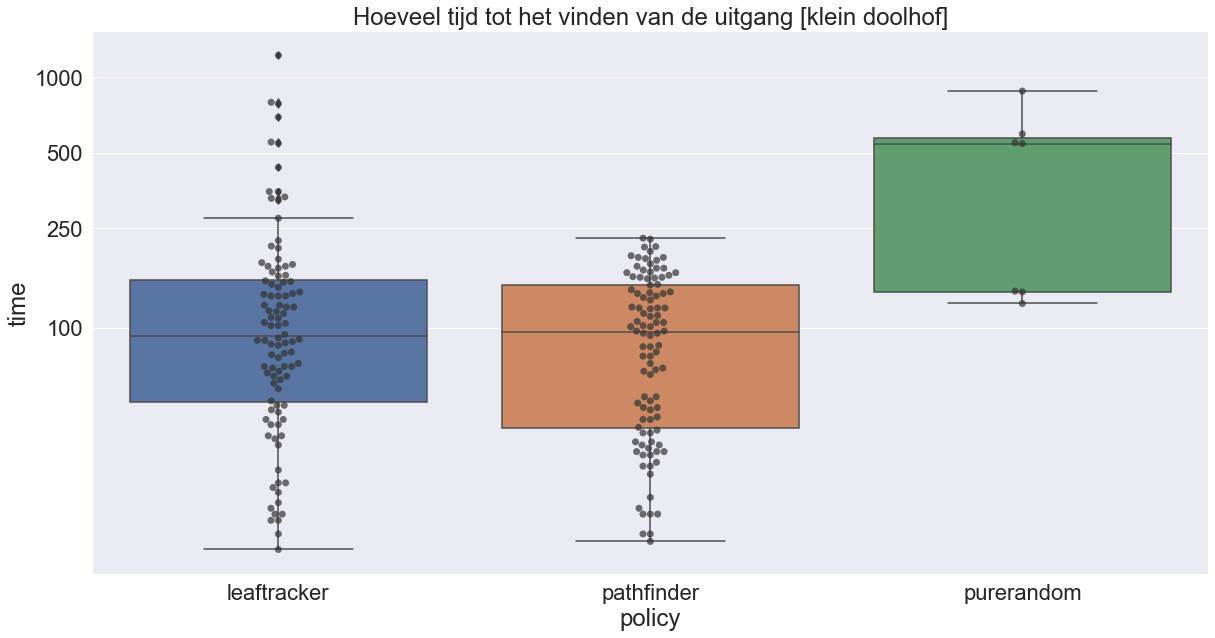

In [184]:
plt.figure(figsize=(20, 10))
ax = sns.boxplot(data=base_small_alive, x='policy', y='time')

ax.set_yscale("log")
y_points = [100, 250, 500, 750, 1000, 2500]
ax.set_yticks(y_points)
ax.set_yticklabels(y_points)

ax = ax.set_title('Hoeveel tijd tot het vinden van de uitgang [klein doolhof]')

ax = sns.swarmplot(data=base_small_alive, x='policy', y='time',color='.2', alpha=0.7, size=7)

### Analyse

Wat hier opvalt is dat er in verschillende simulaties een PureRandom agent is die de uitgang vind zonder dood te gaan. Eigenlijk verwachte we dat dat niet zou gebeuren. Verder lijkt de Leaftracker iets sneller de uitgang te vinden dan de pathfinder.

#### Groot doolhof

- Grootte: 40x40
- 30 batches per policy
- Slowness = 0
- Memory Decay = 0

In [160]:
df_lt = feather.read_feather('baseline/baseline_big/baseline_leaftracker_big.feather').assign(policy='leaftracker')
df_pf = feather.read_feather('baseline/baseline_big/baseline_pathfinder_big.feather').assign(policy='pathfinder')
df_pr = feather.read_feather('baseline/baseline_big/baseline_purerandom_big.feather').assign(policy='purerandom')

base_big_all = pd.concat([df_lt, df_pf, df_pr], axis=0).assign(size='big')
base_big_alive = base_big_all[base_big_all.found_exit != -1]

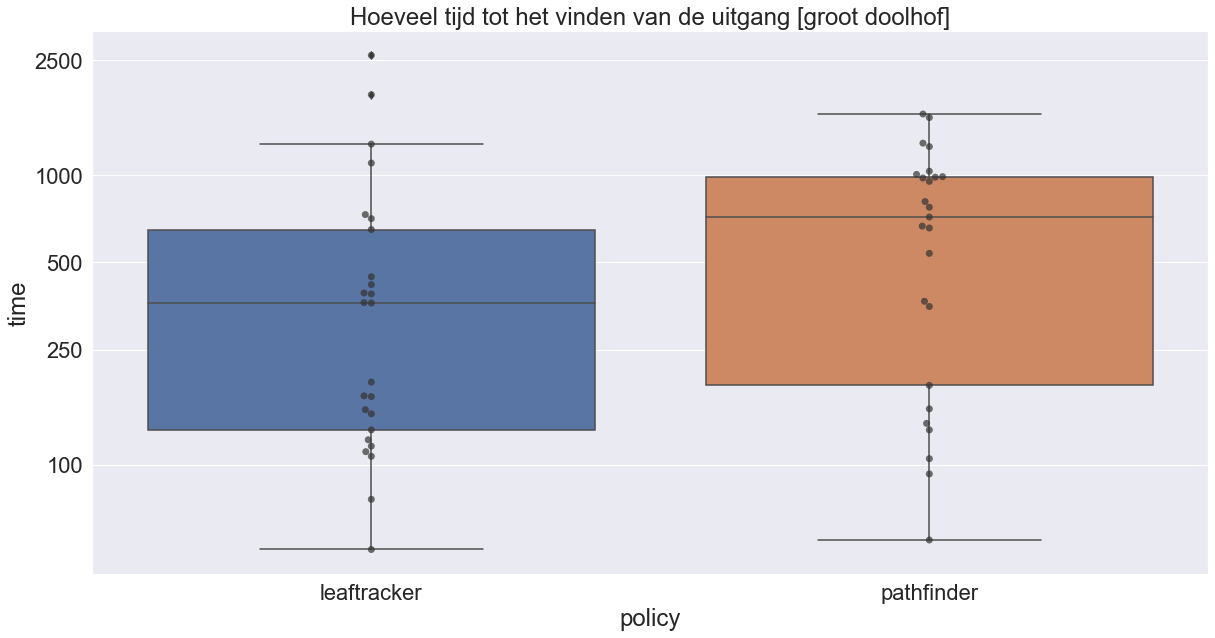

In [177]:
plt.figure(figsize=(20, 10))
ax = sns.boxplot(data=base_big_alive, x='policy', y='time')

ax.set_yscale("log")
y_points = [100, 250, 500, 750, 1000, 2500]
ax.set_yticks(y_points)
ax.set_yticklabels(y_points)

ax = ax.set_title('Hoeveel tijd tot het vinden van de uitgang [groot doolhof]')

ax = sns.swarmplot(data=base_big_alive, x='policy', y='time',color='.2', alpha=0.7, size=7)

### Analyse

Hier zie je dat er geen PureRandom agent meer is die de uitgang kan vinden, wat wel voor te stellen is bij een 40x40 maze. Bij deze lijkt het algoritme van de pathfinder toch beter in het vinden van de buitenkant van de maze en is gemiddeld gezien sneller bij een grotere maze.

In [203]:
df_base_all = pd.concat([base_small_all, base_big_all])
df_base_alive = df_base_all[df_base_all.found_exit != -1]

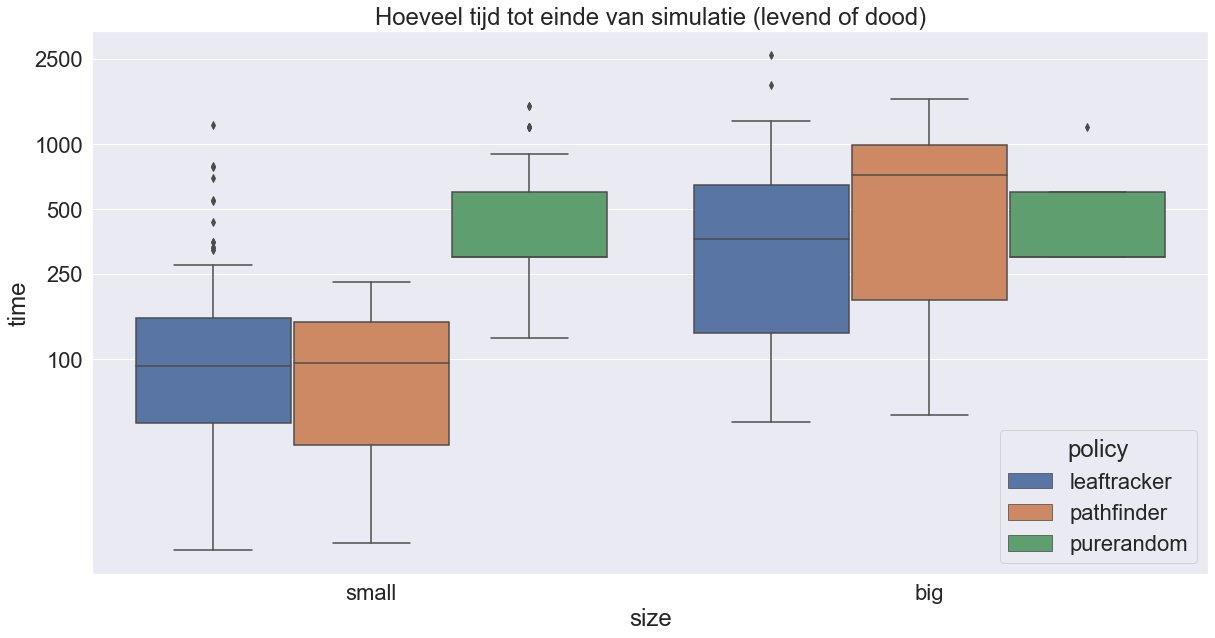

In [204]:
plt.figure(figsize=(20, 10))
ax = sns.boxplot(data=df_base_all, x='size', y='time', hue='policy', width=0.85)

ax.set_yscale("log")
y_points = [100, 250, 500, 750, 1000, 2500]
ax.set_yticks(y_points)
ax.set_yticklabels(y_points)

ax = ax.set_title('Hoeveel tijd tot einde van simulatie (levend of dood)')


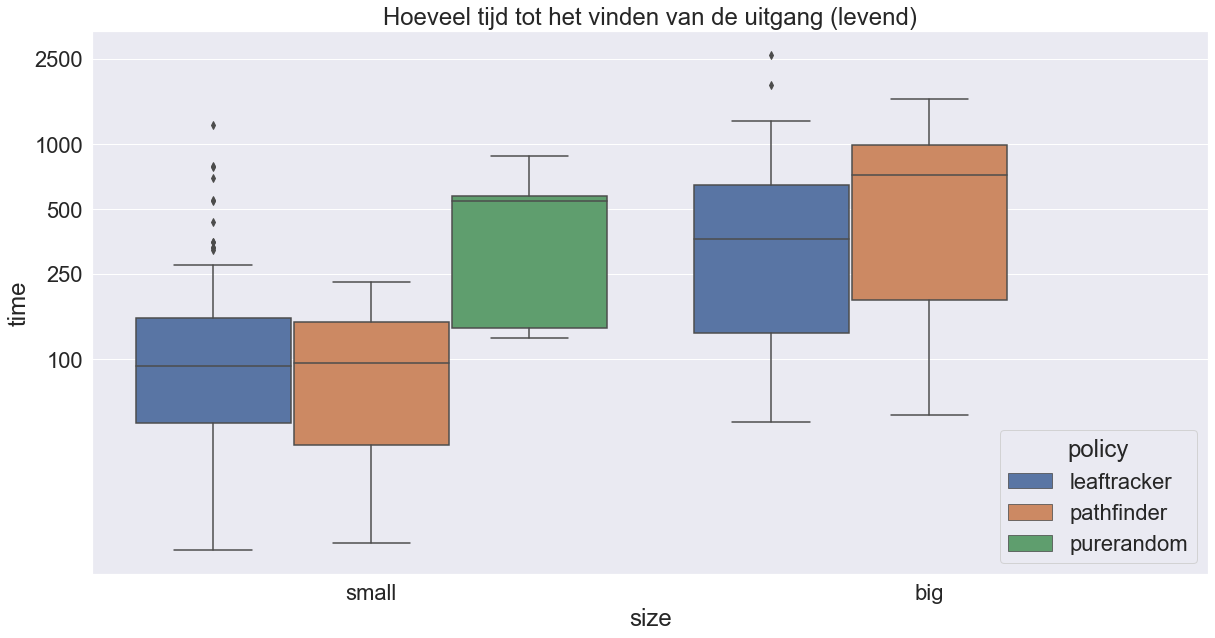

In [181]:
plt.figure(figsize=(20, 10))
ax = sns.boxplot(data=df_base_alive, x='size', y='time', hue='policy', width=0.85)

ax.set_yscale("log")
y_points = [100, 250, 500, 750, 1000, 2500]
ax.set_yticks(y_points)
ax.set_yticklabels(y_points)

ax = ax.set_title('Hoeveel tijd tot het vinden van de uitgang (levend)')

## Slowness

Bij deze analyse laten wij de verschilden snelheden zien van de policies om de uitgang te vinden. Het is verwarrend om het woordje 'snelheid' te gebruiken omdat binnen de simulatie een lage speed juist een snellere agent oplevert. Dit is de rede dat we nu met 'slowness' praten, hoe hoger het getal hoe langzamer de agent is.

- Grootte: 20x20
- 150 batches per policy
- Slowness = Variabel
- Memory Decay = 0

In [33]:
filenames = glob.glob('speed_difference/*.feather')

dfs = []
for filename in filenames:
    # print(filename)
    temp_df = feather.read_feather(filename)
    file_split = filename.split("_")
    policy_type = file_split[3]
    temp_df['slowness'] = int(file_split[4].rsplit(".")[0])
    temp_df['policy'] = policy_type
    dfs.append(temp_df)


# Concatenate all data into one DataFrame
speed_all = pd.concat(dfs, ignore_index=True)
speed_all = speed_all.sort_values(by=['slowness'])
speed_all_alive = speed_all[speed_all.found_exit != -1]


In [36]:
speed_all

,time,found_exit,n_alive,explored,slowness,policy
0,40,0,1,"[[[False, False, False, False, False, False, F...",0,leaftracker
7552,300,-1,0,"[[[True, True, True, True, True, False, False,...",0,purerandom
7551,600,-1,0,"[[[False, False, False, False, False, False, F...",0,purerandom
7550,300,-1,0,"[[[False, False, False, False, False, False, F...",0,purerandom
7549,900,-1,0,"[[[False, False, False, False, False, False, F...",0,purerandom
...,...,...,...,...,...,...
2600,30001,-1,1,"[[[False, False, False, False, False, False, F...",24,leaftracker
2601,30001,-1,1,"[[[False, False, False, False, False, False, F...",24,leaftracker
2602,30001,-1,1,"[[[False, False, False, False, False, False, F...",24,leaftracker
2604,30001,-1,1,"[[[False, False, False, False, False, False, F...",24,leaftracker


In [37]:
speed_all_alive

,time,found_exit,n_alive,explored,slowness,policy
0,40,0,1,"[[[False, False, False, False, False, False, F...",0,leaftracker
7507,220,0,1,"[[[False, False, False, True, True, True, True...",0,purerandom
7577,441,0,1,"[[[False, False, False, False, False, False, F...",0,purerandom
7603,226,0,1,"[[[False, False, False, False, False, False, F...",0,purerandom
3899,178,0,1,"[[[True, True, True, True, True, True, True, T...",0,pathfinder
...,...,...,...,...,...,...
1304,1021,0,1,"[[[False, False, False, False, False, False, F...",16,leaftracker
1295,1021,0,1,"[[[False, False, False, False, False, False, F...",16,leaftracker
5046,1021,0,1,"[[[False, False, False, False, False, False, F...",16,pathfinder
5055,2823,0,1,"[[[False, False, False, False, False, False, F...",16,pathfinder


Hier zien we dat vanaf een slowness van 16 iedere agent niet de uitgang vind.

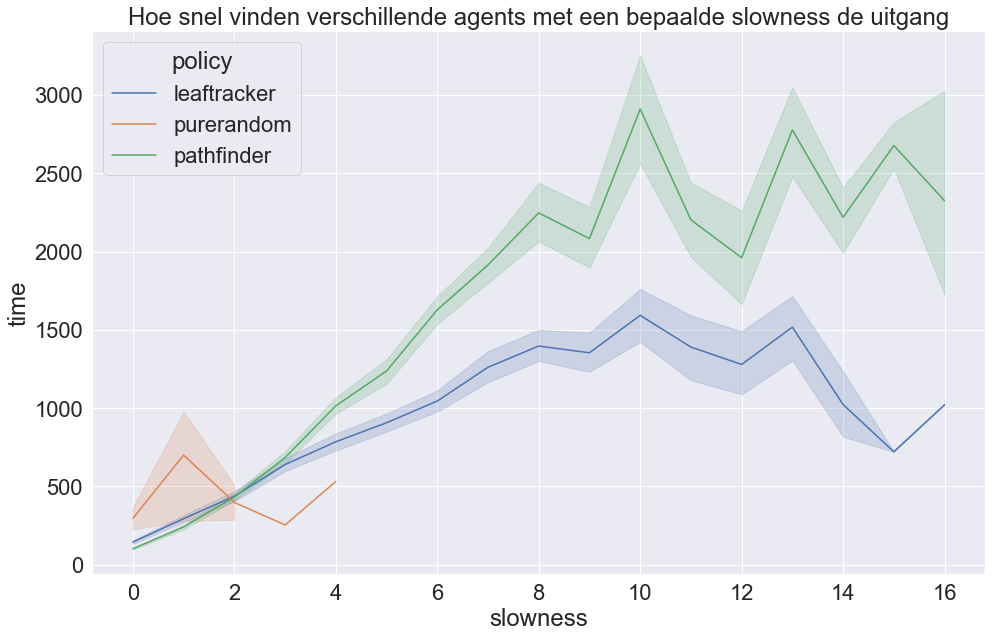

In [34]:
plt.figure(figsize=(16, 10))
ax = sns.lineplot(data=speed_all_alive, x="slowness", y="time", hue="policy", ci=68)
ax = ax.set_title('Hoe snel vinden verschillende agents met een bepaalde slowness de uitgang')

### Analyse

Purerandom: Er zijn meerdere purerandom agents die de uitgang vinden met een slowness tussen de 0 en de 2, enkele weten dit ook nog te doen met een slowness van 4, maar daarna vind geen 1 agent meer de uitgang.

Bij de andere twee agents zien we dat ze steeds verder uit elkaar gaan liggen bij een hogere slowness, duidelijk is hier dat de leaftracker beter presteerd dan de pathfinder. dit bewijst dat de uitbereiding van de leaftracker ten opzichte van de pathfinder er ook daadwerkelijk voor zorgd dat de agent sneller de uitgang vind.

Het experiment heeft zich afgespeeld tussen een slowness van 0 en 24, we kunnen dus stellen dat agents met een slowness groter dan 16 niet kunnen ontsnappen uit de maze (met deze settings!)


## Memory decay

Hier gaan we kijken hoeveel memory decay invloed heeft op de tijd die het kost om de uitgang te vinden. Belangrijk is dat memory decay elke nacht gebeurt, wanneer een agent de uitgang in 1 dag vind heeft deze er dus geen last van.

- Grootte: 20x20
- 100 batches per policy
- Slowness = 0
- Memory Decay = Variabel

In [25]:
filenames = glob.glob('memory_decay/*.feather')

dfs = []
for filename in filenames:
    # print(filename)
    temp_df = feather.read_feather(filename)
    file_split = filename.split("_")
    policy_type = file_split[3]
    # print(file_split[4])
    temp_df['decay'] = int(file_split[4].rsplit(".")[0])
    temp_df['policy'] = policy_type
    dfs.append(temp_df)

# Concatenate all data into one DataFrame
decay_all = pd.concat(dfs, ignore_index=True)
decay_all = decay_all.sort_values(by=['decay'])
decay_all_alive = decay_all[decay_all.found_exit != -1]

Text(0.5, 1.0, 'Hoe snel vinden verschillende agents met een bepaalde decay de uitgang')

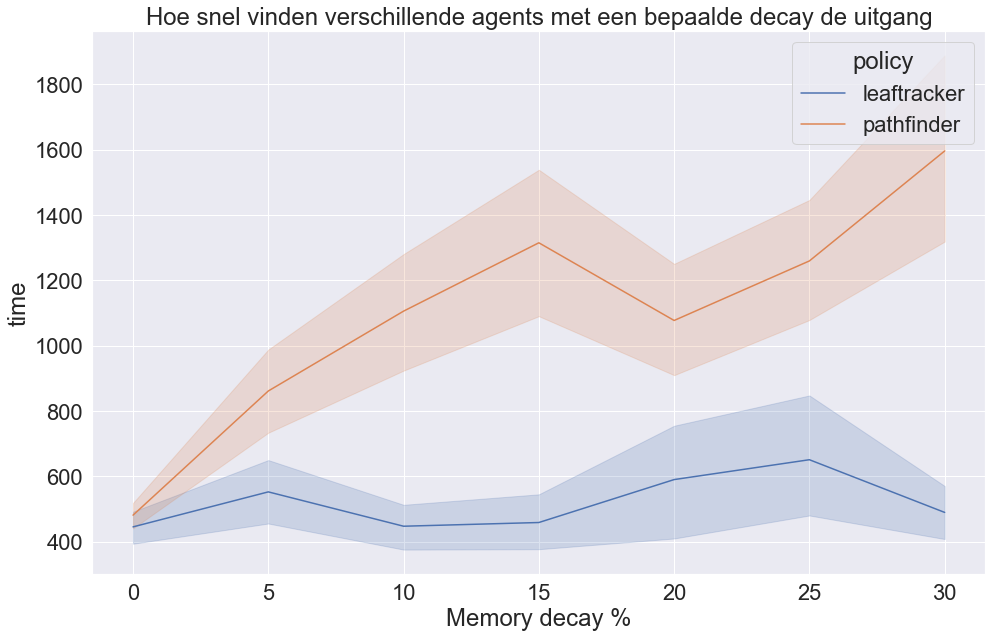

In [38]:
plt.figure(figsize=(16, 10))
ax = sns.lineplot(data=decay_all_alive, x="decay", y="time", hue="policy", ci=68)
ax.set(xlabel='Memory decay %')
ax.set_title('Hoe snel vinden verschillende agents met een bepaalde decay de uitgang')

### Analyse

Het is te zien dat de leaftracker niet echt beinvloed word door memory decay. Wel zien we bij de pathfinder dat deze omhoog schiet wanneer de agents meer van hun kaart vergeten. Dit komt waarschijnlijk omdat de pathfinding agent dan niet meer met zekerheid een pad kunnen kiezen waar de leaftrackers zich voorral bezig houden met de verspreiding van de blaadjes.

We kunnen de gekke dip bij 20% decay niet direct verklaren, dit zal waarschijlijk niet gebeuren wanneer er heel veel batches gerund zouden worden.

# Multiagent


### All Policies

- Grootte: 20x20
- 100 batches per simulatie
- Slowness = 0
- Memory Decay = 0

Belangrijk:
- Agent #0 = PureRandom
- Agent #1 = PathFinding
- Agent #2 = LeafTracker

In [77]:
df_all_policies = feather.read_feather('multiagent_experiment/all_policies/all_policies.feather')

"""Int values to string representation"""
df_all_policies['found_exit'] = df_all_policies['found_exit'].replace([0],'purerandom')
df_all_policies['found_exit'] = df_all_policies['found_exit'].replace([1],'pathfinding')
df_all_policies['found_exit'] = df_all_policies['found_exit'].replace([2],'leaftracker')


"""Count number of exitst per policy"""
df_all_policies_count = df_all_policies['found_exit'].value_counts()

Text(0.5, 1.0, 'Welke agent vind als eerste de uitgang?')

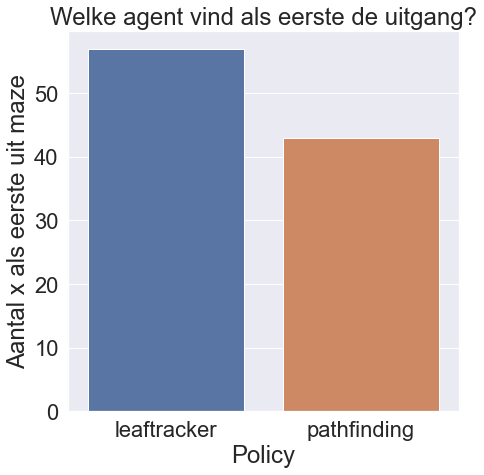

In [84]:
plt.figure(figsize=(7, 7))


ax = sns.barplot( x=df_all_policies_count.index, y=df_all_policies_count)
ax.set(ylabel='Aantal x als eerste uit maze')
ax.set(xlabel='Policy')
ax.set_title('Welke agent vind als eerste de uitgang?')

### Analyse

Leaftracker vind vaker de uitgang als eerste, PureRandom vind hem nooit als eerste

## Baseline Small
We testen voor elke policy hoe 3 samenwerkende agents presteren

- Grootte: 20x20
- 100 batches per simulatie
- Slowness = 0
- Memory Decay = 0
- Aantal agent van zelfde policy: 3

In [88]:
# df_multi_baseline_small = feather.read_feather('multiagent_experiment/baseline/baseline_small/all_policies.feather')

df_lt = feather.read_feather('multiagent_experiment/baseline/baseline_small/baseline_leaftracker_small.feather').assign(policy='leaftracker')
df_pf = feather.read_feather('multiagent_experiment/baseline/baseline_small/baseline_pathfinder_small.feather').assign(policy='pathfinder')
df_pr = feather.read_feather('multiagent_experiment/baseline/baseline_small/baseline_purerandom_small.feather').assign(policy='purerandom')

df_multi_baseline_small_all = pd.concat([df_lt, df_pf, df_pr], axis=0).assign(size='big')
df_multi_baseline_small_alive = df_multi_baseline_small_all[df_multi_baseline_small_all.found_exit != -1]


# """Count number of exitst per policy"""
# df_all_policies_count = df_all_policies['found_exit'].value_counts()

In [ ]:
df_multi_baseline_small_all

In [90]:
df_lt = feather.read_feather('multiagent_experiment/baseline/baseline_big/baseline_leaftracker_big.feather').assign(policy='leaftracker')
df_pf = feather.read_feather('multiagent_experiment/baseline/baseline_big/baseline_pathfinder_big.feather').assign(policy='pathfinder')
df_pr = feather.read_feather('multiagent_experiment/baseline/baseline_big/baseline_purerandom_big.feather').assign(policy='purerandom')

df_multi_baseline_big_all = pd.concat([df_lt, df_pf, df_pr], axis=0).assign(size='big')
df_multi_baseline_big_alive = df_multi_baseline_big_all[df_multi_baseline_big_all.found_exit != -1]


In [95]:
df_multi_baseline_all = pd.concat([df_multi_baseline_small_all, df_multi_baseline_big_all])
df_multi_baseline_alive = df_multi_baseline_all[df_multi_baseline_all.found_exit != -1]
df_multi_baseline_alive

,time,found_exit,n_alive,explored,policy,size
0,29,0,3,"[[[False, False, False, False, False, False, F...",leaftracker,big
1,22,2,3,"[[[False, False, False, False, False, False, F...",leaftracker,big
2,33,0,3,"[[[False, False, False, False, False, False, F...",leaftracker,big
3,27,0,3,"[[[False, False, False, False, False, False, F...",leaftracker,big
4,37,0,3,"[[[False, False, False, False, False, False, F...",leaftracker,big
...,...,...,...,...,...,...
20,459,2,3,"[[[False, False, False, False, False, False, F...",pathfinder,big
21,737,0,3,"[[[True, True, True, True, True, True, True, T...",pathfinder,big
22,665,0,3,"[[[False, False, False, False, False, False, F...",pathfinder,big
23,699,1,3,"[[[False, False, False, False, False, False, F...",pathfinder,big


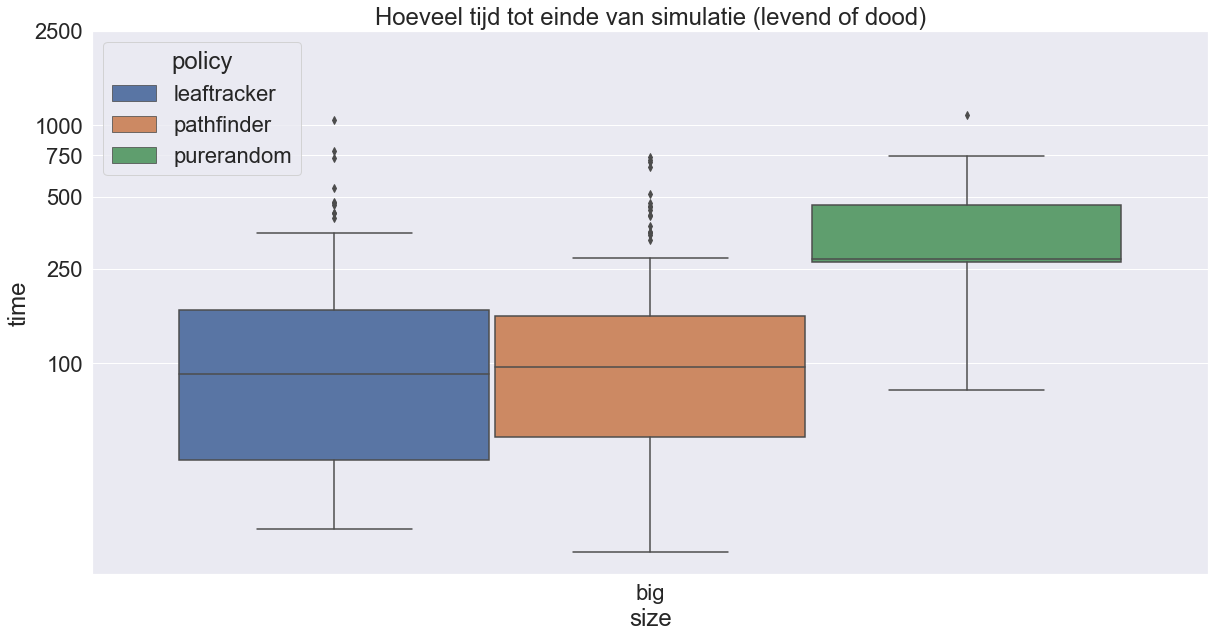

In [98]:
plt.figure(figsize=(20, 10))
ax = sns.boxplot(data=df_multi_baseline_alive, x='size', y='time', hue='policy', width=0.85)

ax.set_yscale("log")
y_points = [100, 250, 500, 750, 1000, 2500]
ax.set_yticks(y_points)
ax.set_yticklabels(y_points)

ax = ax.set_title('Hoeveel tijd tot einde van simulatie (levend of dood)')


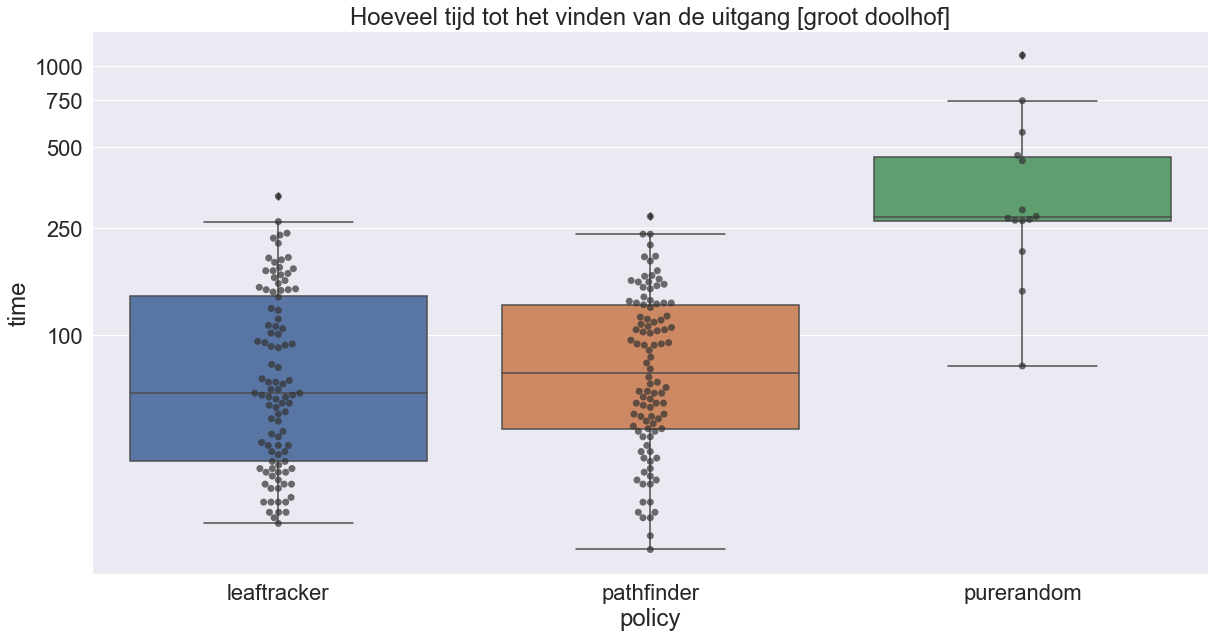

In [89]:
plt.figure(figsize=(20, 10))
ax = sns.boxplot(data=df_multi_baseline_small_alive, x='policy', y='time')

ax.set_yscale("log")
y_points = [100, 250, 500, 750, 1000, 2500]
ax.set_yticks(y_points)
ax.set_yticklabels(y_points)

ax = ax.set_title('Hoeveel tijd tot het vinden van de uitgang [klein doolhof]')

ax = sns.swarmplot(data=df_multi_baseline_small_alive, x='policy', y='time',color='.2', alpha=0.7, size=7)